In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Import metrics
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    matthews_corrcoef,
    confusion_matrix, 
    classification_report, 
    roc_curve,
    auc
)

print("Machine learning libraries imported successfully")


Machine learning libraries imported successfully


In [3]:
# Load dataset
dataset_path = 'fake_job_postings.csv'

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found: {dataset_path}")

df = pd.read_csv(dataset_path)

print("Dataset loaded successfully")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nTarget distribution:")
print(df['fraudulent'].value_counts())
print(f"\nClass percentages:")
print(df['fraudulent'].value_counts(normalize=True) * 100)


Dataset loaded successfully
Shape: 17880 rows, 18 columns

Target distribution:
fraudulent
0    17014
1      866
Name: count, dtype: int64

Class percentages:
fraudulent
0    95.1566
1     4.8434
Name: proportion, dtype: float64


In [4]:
"""
Dataset Loading and Initial Inspection
======================================
Loading the fake job postings dataset and performing initial checks
"""

import os
import pandas as pd

# Configuration
DATASET_FILE = 'fake_job_postings.csv'
RANDOM_STATE = 42

print("="*80)
print(" "*25 + "DATASET LOADING")
print("="*80)

# Verify file existence
if not os.path.exists(DATASET_FILE):
    raise FileNotFoundError(
        f"\n Dataset not found: {DATASET_FILE}\n"
        f" Download from Kaggle and place in model/ folder\n"
        f"https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction"
    )

# Load dataset
data = pd.read_csv(DATASET_FILE)

# Display loading summary
print(f"\nDataset loaded successfully")
print(f"\n Dataset Dimensions:")
print(f"   • Samples (rows): {data.shape[0]:,}")
print(f"   • Features (columns): {data.shape[1]}")
print(f"   • Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n Target Variable: 'fraudulent'")
print(f"   • Class 0 (Legitimate): {(data['fraudulent']==0).sum():,}")
print(f"   • Class 1 (Fraudulent): {(data['fraudulent']==1).sum():,}")
print(f"   • Imbalance ratio: 1:{(data['fraudulent']==0).sum()/(data['fraudulent']==1).sum():.1f}")

print("\n" + "="*80)


                         DATASET LOADING

Dataset loaded successfully

 Dataset Dimensions:
   • Samples (rows): 17,880
   • Features (columns): 18
   • Memory usage: 81.14 MB

 Target Variable: 'fraudulent'
   • Class 0 (Legitimate): 17,014
   • Class 1 (Fraudulent): 866
   • Imbalance ratio: 1:19.6



Columns with missing values:
             column  missing_count  missing_percentage
       salary_range          15012               83.96
         department          11547               64.58
 required_education           8105               45.33
           benefits           7212               40.34
required_experience           7050               39.43
           function           6455               36.10
           industry           4903               27.42
    employment_type           3471               19.41
    company_profile           3308               18.50
       requirements           2696               15.08
           location            346                1.94
        description              1                0.01


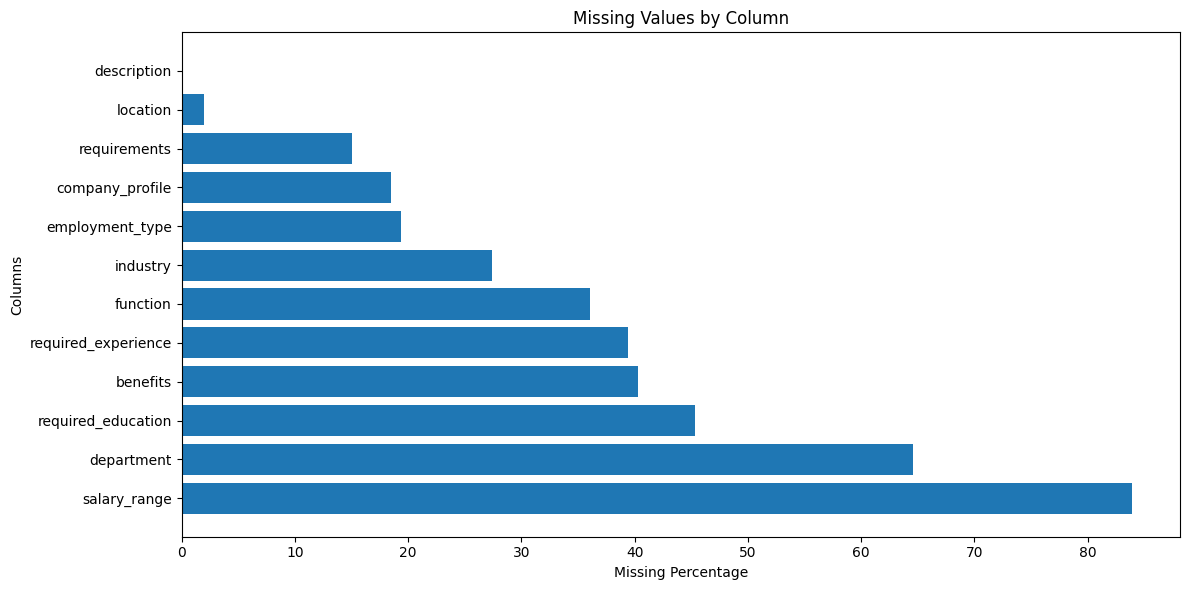

In [5]:
# Analyze missing values
missing_data = pd.DataFrame({
    'column': df.columns,
    'missing_count': df.isnull().sum(),
    'missing_percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

missing_data = missing_data[missing_data['missing_count'] > 0]
missing_data = missing_data.sort_values('missing_percentage', ascending=False)

print("Columns with missing values:")
print(missing_data.to_string(index=False))

# Visualize missing values
if len(missing_data) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(missing_data['column'], missing_data['missing_percentage'])
    plt.xlabel('Missing Percentage')
    plt.ylabel('Columns')
    plt.title('Missing Values by Column')
    plt.tight_layout()
    plt.show()


In [6]:
# Define features to use
structured_features = ['telecommuting', 'has_company_logo', 'has_questions']
categorical_features = ['employment_type', 'required_experience', 'required_education', 
                       'industry', 'function']
text_columns = ['company_profile', 'description', 'requirements', 'benefits']

# Create binary features from text columns
print("Creating binary features from text columns...")
for col in text_columns:
    new_col = f'has_{col}'
    df[new_col] = df[col].notna().astype(int)
    print(f"Created: {new_col}")

# Combine all features
feature_columns = structured_features + categorical_features + [f'has_{col}' for col in text_columns]

print(f"\nTotal features selected: {len(feature_columns)}")
print("Features:", feature_columns)

# Create feature matrix and target
X = df[feature_columns].copy()
y = df['fraudulent'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Creating binary features from text columns...
Created: has_company_profile
Created: has_description
Created: has_requirements
Created: has_benefits

Total features selected: 12
Features: ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'has_company_profile', 'has_description', 'has_requirements', 'has_benefits']

Feature matrix shape: (17880, 12)
Target vector shape: (17880,)


In [7]:
# Handle missing values in categorical columns
print("Handling missing values...")

for col in categorical_features:
    missing_count = X[col].isnull().sum()
    if missing_count > 0:
        X[col] = X[col].fillna('Unknown')
        print(f"{col}: filled {missing_count} missing values")

# Verify no missing values remain
total_missing = X.isnull().sum().sum()
print(f"\nTotal missing values after handling: {total_missing}")

if total_missing == 0:
    print("All missing values handled successfully")


Handling missing values...
employment_type: filled 3471 missing values
required_experience: filled 7050 missing values
required_education: filled 8105 missing values
industry: filled 4903 missing values
function: filled 6455 missing values

Total missing values after handling: 0
All missing values handled successfully


In [8]:
# Encode categorical variables
label_encoders = {}

print("Encoding categorical variables...")

for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    
    print(f"{col}: {len(le.classes_)} unique values encoded to [0, {len(le.classes_)-1}]")

print(f"\nEncoding completed. Total encoders created: {len(label_encoders)}")

# Verify all features are numeric
print("\nData types after encoding:")
print(X.dtypes.value_counts())


Encoding categorical variables...
employment_type: 6 unique values encoded to [0, 5]
required_experience: 8 unique values encoded to [0, 7]
required_education: 14 unique values encoded to [0, 13]
industry: 132 unique values encoded to [0, 131]
function: 38 unique values encoded to [0, 37]

Encoding completed. Total encoders created: 5

Data types after encoding:
int64    12
Name: count, dtype: int64


In [9]:
# Split data into train and test sets
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=random_state, 
    stratify=y
)

print(f"Train-test split completed with {int(test_size*100)}% test size")
print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print("\nTraining set class distribution:")
print(f"Legitimate: {(y_train==0).sum()}")
print(f"Fraudulent: {(y_train==1).sum()}")

print("\nTest set class distribution:")
print(f"Legitimate: {(y_test==0).sum()}")
print(f"Fraudulent: {(y_test==1).sum()}")
# ---------------------------------------------
# Save test.csv for Streamlit App
# ---------------------------------------------

test_df = X_test.copy()
test_df['fraudulent'] = y_test

test_df.to_csv("test.csv", index=False)

print("test.csv saved successfully!")
print(f"Shape: {test_df.shape}")



Train-test split completed with 20% test size

Training set: (14304, 12)
Test set: (3576, 12)

Training set class distribution:
Legitimate: 13611
Fraudulent: 693

Test set class distribution:
Legitimate: 3403
Fraudulent: 173
test.csv saved successfully!
Shape: (3576, 13)


In [10]:
# Scale features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed using StandardScaler")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

# Verify scaling
print(f"\nScaled data statistics:")
print(f"Mean: {X_train_scaled.mean():.6f}")
print(f"Standard deviation: {X_train_scaled.std():.6f}")


Feature scaling completed using StandardScaler
Scaled training set shape: (14304, 12)
Scaled test set shape: (3576, 12)

Scaled data statistics:
Mean: 0.000000
Standard deviation: 1.000000


In [11]:
# Calculate class weight for XGBoost
n_legitimate = (y_train == 0).sum()
n_fraudulent = (y_train == 1).sum()
scale_pos_weight = n_legitimate / n_fraudulent

print(f"Class weight ratio: {scale_pos_weight:.2f}")

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=random_state,
        solver='lbfgs'
    ),
    
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=random_state
    ),
    
    'K-Nearest Neighbors': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(
            n_neighbors=15,
            weights='distance',
            metric='minkowski',
            p=2,
            n_jobs=-1
        ))
    ]),
    
    'Naive Bayes': GaussianNB(),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=random_state,
        n_jobs=-1
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=random_state,
        eval_metric='logloss',
        use_label_encoder=False
    )
}

print("Models initialized:")
for i, name in enumerate(models.keys(), 1):
    print(f"{i}. {name}")


Class weight ratio: 19.64
Models initialized:
1. Logistic Regression
2. Decision Tree
3. K-Nearest Neighbors
4. Naive Bayes
5. Random Forest
6. XGBoost


In [12]:
# Train all models
import time

trained_models = {}
training_times = {}

print("Training models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    start_time = time.time()
    
    # Use scaled data only for Logistic Regression and KNN
   
    model.fit(X_train, y_train)

    end_time = time.time()
    training_time = end_time - start_time
    
    trained_models[name] = model
    training_times[name] = training_time
    
    print(f"Training completed in {training_time:.2f} seconds\n")

print("All models trained successfully")



Training models...

Training Logistic Regression...
Training completed in 0.56 seconds

Training Decision Tree...
Training completed in 0.02 seconds

Training K-Nearest Neighbors...
Training completed in 0.04 seconds

Training Naive Bayes...
Training completed in 0.01 seconds

Training Random Forest...
Training completed in 0.25 seconds

Training XGBoost...
Training completed in 0.12 seconds

All models trained successfully


In [13]:
results = []
confusion_matrices = {}

for name, model in trained_models.items():
    print(f"Evaluating {name}...")
    
    X_eval = X_test
    
    # Predictions
    y_pred = model.predict(X_eval)
    
    # Probability handling
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_eval)[:, 1]
    else:
        y_pred_proba = y_pred
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    metrics = {
        'Model': name,
        'Accuracy': accuracy,
        'AUC Score': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC Score': mcc
    }
    
    results.append(metrics)
    
    # Store confusion matrix correctly
    # confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy : {accuracy:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Recall   : {recall:.4f}")
    print("-" * 40)

# Create results dataframe
results_df = pd.DataFrame(results)

# Sort by F1 Score
results_df = results_df.sort_values(by='F1 Score', ascending=False)

results_df = results_df[
    ['Model', 'Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC Score']
].round(4)

print("=" * 80)
print("Model Evaluation Results (Sorted by F1 Score)")
print("=" * 80)
print(results_df.to_string(index=False))


Evaluating Logistic Regression...
Accuracy : 0.8191
F1 Score : 0.2485
Recall   : 0.6185
----------------------------------------
Evaluating Decision Tree...
Accuracy : 0.8708
F1 Score : 0.3889
Recall   : 0.8497
----------------------------------------
Evaluating K-Nearest Neighbors...
Accuracy : 0.9706
F1 Score : 0.6182
Recall   : 0.4913
----------------------------------------
Evaluating Naive Bayes...
Accuracy : 0.9432
F1 Score : 0.0645
Recall   : 0.0405
----------------------------------------
Evaluating Random Forest...
Accuracy : 0.9155
F1 Score : 0.4881
Recall   : 0.8324
----------------------------------------
Evaluating XGBoost...
Accuracy : 0.9253
F1 Score : 0.5206
Recall   : 0.8382
----------------------------------------
Model Evaluation Results (Sorted by F1 Score)
              Model  Accuracy  AUC Score  Precision  Recall  F1 Score  MCC Score
K-Nearest Neighbors    0.9706     0.9134     0.8333  0.4913    0.6182     0.6269
            XGBoost    0.9253     0.9460     0.377

In [14]:
# Evaluate all models
results = []

print("Evaluating models...\n")

for name, model in trained_models.items():
    print(f"Evaluating {name}...")
    
    # Use scaled data only for Logistic Regression and KNN
    use_scaled = name in ['Logistic Regression', 'K-Nearest Neighbors']
    
    if use_scaled:
        X_eval = X_test_scaled
    else:
        X_eval = X_test
    
    # Make predictions
    y_pred = model.predict(X_eval)
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC Score': roc_auc_score(y_test, y_pred_proba),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'MCC Score': matthews_corrcoef(y_test, y_pred)
    }
    
    results.append(metrics)
    
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}\n")

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC Score']]
results_df = results_df.round(4)

print("="*80)
print("Model Evaluation Results:")
print("="*80)
print(results_df.to_string(index=False))


Evaluating models...

Evaluating Logistic Regression...
Accuracy: 0.0716
F1 Score: 0.0944

Evaluating Decision Tree...
Accuracy: 0.8708
F1 Score: 0.3889

Evaluating K-Nearest Neighbors...
Accuracy: 0.1418
F1 Score: 0.0831

Evaluating Naive Bayes...
Accuracy: 0.9432
F1 Score: 0.0645

Evaluating Random Forest...
Accuracy: 0.9155
F1 Score: 0.4881

Evaluating XGBoost...
Accuracy: 0.9253
F1 Score: 0.5206

Model Evaluation Results:
              Model  Accuracy  AUC Score  Precision  Recall  F1 Score  MCC Score
Logistic Regression    0.0716     0.7410     0.0495  1.0000    0.0944     0.0348
      Decision Tree    0.8708     0.9040     0.2521  0.8497    0.3889     0.4191
K-Nearest Neighbors    0.1418     0.4717     0.0438  0.8035    0.0831    -0.0600
        Naive Bayes    0.9432     0.7021     0.1591  0.0405    0.0645     0.0576
      Random Forest    0.9155     0.9445     0.3453  0.8324    0.4881     0.5028
            XGBoost    0.9253     0.9460     0.3776  0.8382    0.5206     0.5322


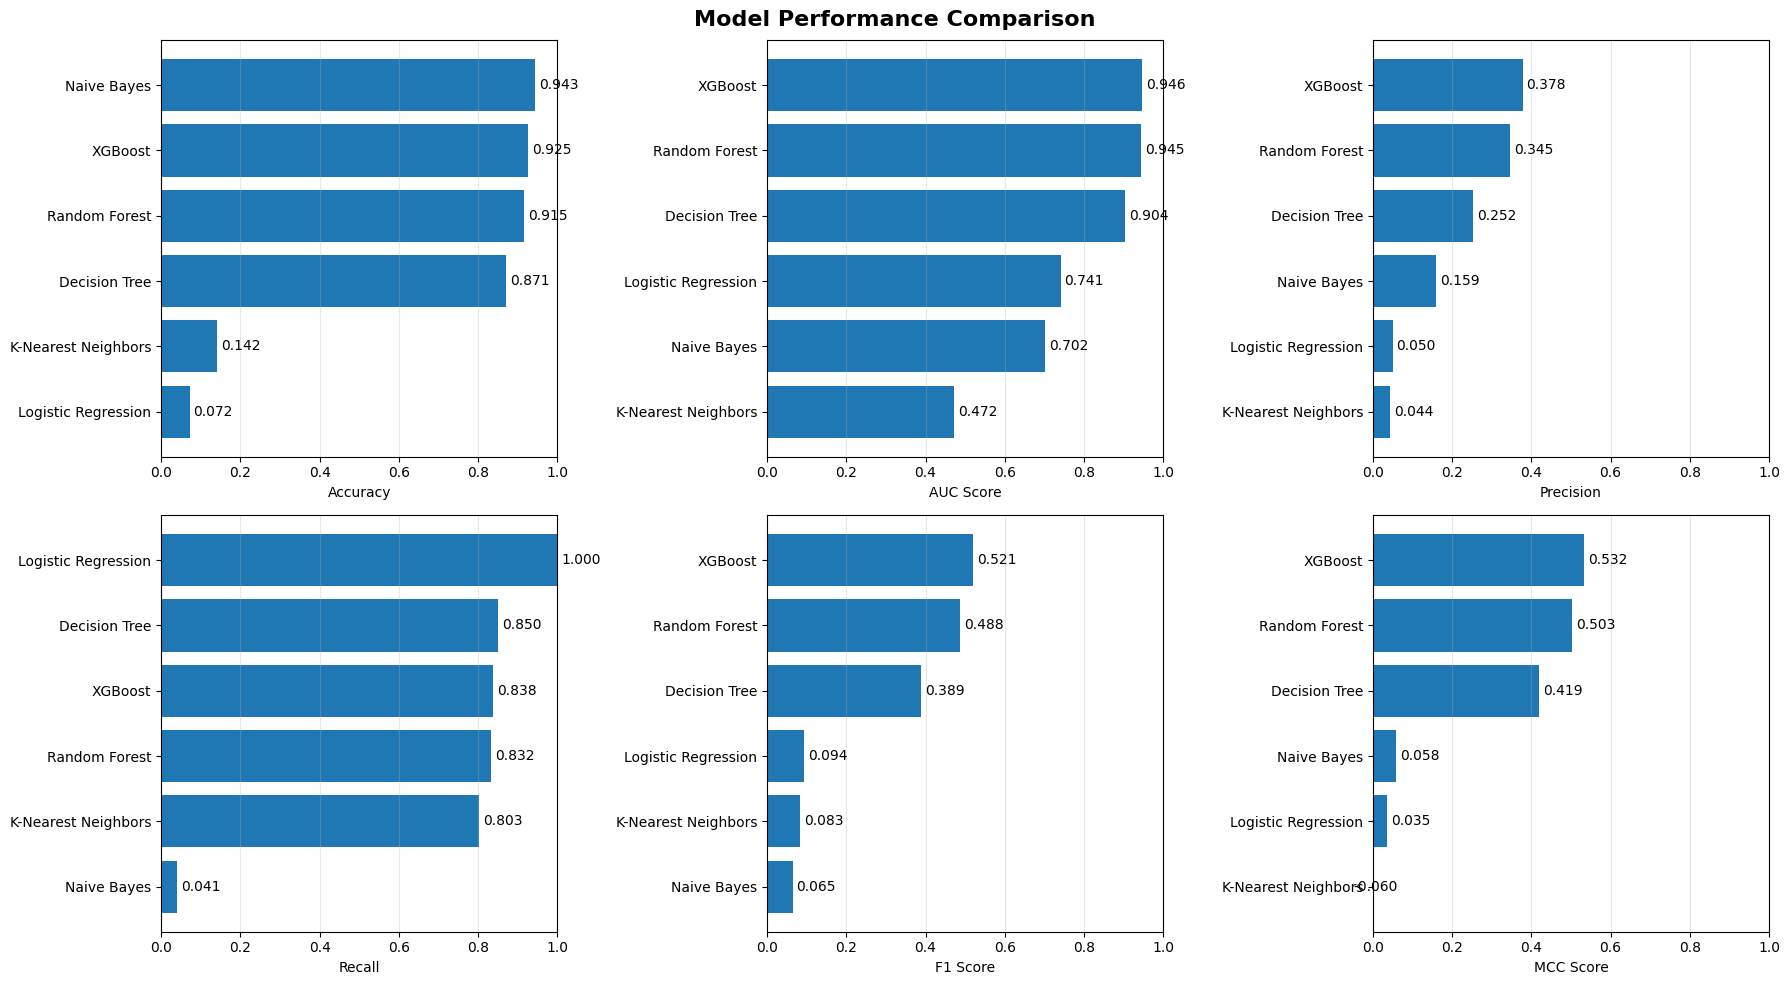

Visualization saved as 'model_comparison.png'


In [15]:
# Visualize model performance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    
    data = results_df.sort_values(metric, ascending=True)
    ax.barh(data['Model'], data[metric])
    ax.set_xlabel(metric)
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'model_comparison.png'")


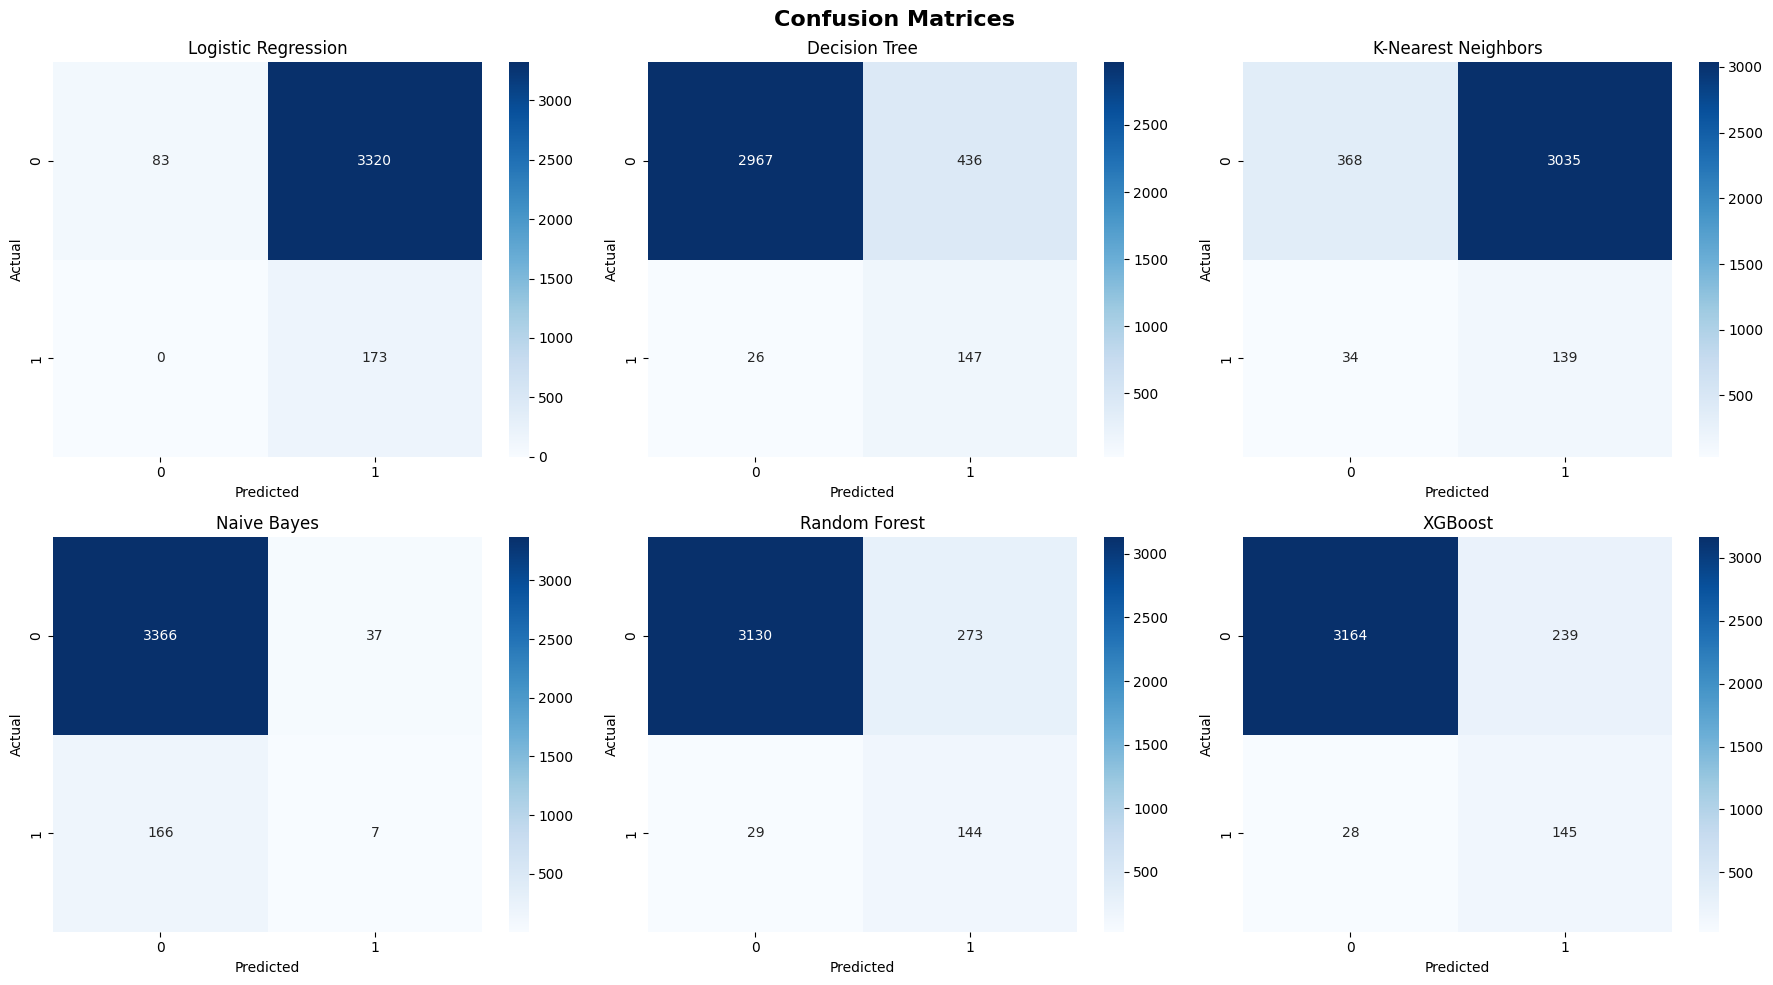

Confusion matrices saved as 'confusion_matrices.png'


In [16]:
# Generate confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

for idx, (name, model) in enumerate(trained_models.items()):
    ax = axes[idx // 3, idx % 3]
    
    # Use scaled data only for Logistic Regression and KNN
    use_scaled = name in ['Logistic Regression', 'K-Nearest Neighbors']
    X_eval = X_test_scaled if use_scaled else X_test
    
    y_pred = model.predict(X_eval)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices saved as 'confusion_matrices.png'")


In [17]:
# Save all models and objects
print("Saving models and preprocessing objects...\n")

for name, model in trained_models.items():
    filename = name.lower().replace(' ', '_')
    filepath = f'{filename}.pkl'
    
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Saved: {filepath}")

# Save preprocessing objects
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved: scaler.pkl")

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("Saved: label_encoders.pkl")

with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)
print("Saved: feature_names.pkl")

# Save results
results_df.to_csv('model_results.csv', index=False)
print("Saved: model_results.csv")

print("\nAll files saved successfully")


Saving models and preprocessing objects...

Saved: logistic_regression.pkl
Saved: decision_tree.pkl
Saved: k-nearest_neighbors.pkl
Saved: naive_bayes.pkl
Saved: random_forest.pkl
Saved: xgboost.pkl
Saved: scaler.pkl
Saved: label_encoders.pkl
Saved: feature_names.pkl
Saved: model_results.csv

All files saved successfully


In [18]:
# Comprehensive model verification
print("Testing saved models...\n")

# Load a saved model
test_model = 'random_forest.pkl'
with open(test_model, 'rb') as f:
    loaded_model = pickle.load(f)

print(f"Loaded model: {test_model}\n")

# Test on multiple samples
n_test_samples = 10
test_indices = np.random.choice(len(X_test), n_test_samples, replace=False)

print(f"Testing on {n_test_samples} random samples:")
print("="*60)

correct_predictions = 0
for i, idx in enumerate(test_indices, 1):
    sample = X_test.iloc[idx:idx+1]
    actual = y_test.iloc[idx]
    
    prediction = loaded_model.predict(sample)[0]
    proba = loaded_model.predict_proba(sample)[0]
    
    match = "CORRECT" if prediction == actual else "WRONG"
    correct_predictions += (prediction == actual)
    
    print(f"Sample {i}:")
    print(f"  Actual: {actual} ({'Fake' if actual == 1 else 'Real'})")
    print(f"  Predicted: {prediction} ({'Fake' if prediction == 1 else 'Real'})")
    print(f"  Probability [Real, Fake]: [{proba[0]:.3f}, {proba[1]:.3f}]")
    print(f"  Result: {match}\n")

accuracy = correct_predictions / n_test_samples
print("="*60)
print(f"Verification accuracy: {accuracy:.2%} ({correct_predictions}/{n_test_samples})")
print("\nModel loading and prediction working correctly")


Testing saved models...

Loaded model: random_forest.pkl

Testing on 10 random samples:
Sample 1:
  Actual: 0 (Real)
  Predicted: 0 (Real)
  Probability [Real, Fake]: [0.950, 0.050]
  Result: CORRECT

Sample 2:
  Actual: 0 (Real)
  Predicted: 0 (Real)
  Probability [Real, Fake]: [0.899, 0.101]
  Result: CORRECT

Sample 3:
  Actual: 0 (Real)
  Predicted: 0 (Real)
  Probability [Real, Fake]: [0.979, 0.021]
  Result: CORRECT

Sample 4:
  Actual: 0 (Real)
  Predicted: 0 (Real)
  Probability [Real, Fake]: [0.861, 0.139]
  Result: CORRECT

Sample 5:
  Actual: 0 (Real)
  Predicted: 0 (Real)
  Probability [Real, Fake]: [0.829, 0.171]
  Result: CORRECT

Sample 6:
  Actual: 0 (Real)
  Predicted: 0 (Real)
  Probability [Real, Fake]: [0.877, 0.123]
  Result: CORRECT

Sample 7:
  Actual: 0 (Real)
  Predicted: 0 (Real)
  Probability [Real, Fake]: [0.626, 0.374]
  Result: CORRECT

Sample 8:
  Actual: 0 (Real)
  Predicted: 0 (Real)
  Probability [Real, Fake]: [0.827, 0.173]
  Result: CORRECT

Sample 9

In [19]:
# Final verification and summary
print("="*80)
print("Training Complete - Files Created")
print("="*80)

# Verify all files exist
required_files = [
    'logistic_regression.pkl',
    'decision_tree.pkl',
    'k-nearest_neighbors.pkl',
    'naive_bayes.pkl',
    'random_forest.pkl',
    'xgboost.pkl',
    'scaler.pkl',
    'label_encoders.pkl',
    'feature_names.pkl',
    'model_results.csv'
]

print("\nFile Verification:")
for filename in required_files:
    exists = os.path.exists(filename)
    status = "✓" if exists else "✗"
    print(f"{status} {filename}")

print("\n" + "="*80)
print("Summary Statistics")
print("="*80)

print(f"\nDataset:")
print(f"  Total samples: {len(df)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features: {len(feature_columns)}")

print(f"\nModels trained: {len(trained_models)}")
print(f"Results saved: model_results.csv")

print("\n" + "="*80)
print("Ready for Streamlit Deployment")
print("="*80)
print("\nRun: streamlit run app.py")


Training Complete - Files Created

File Verification:
✓ logistic_regression.pkl
✓ decision_tree.pkl
✓ k-nearest_neighbors.pkl
✓ naive_bayes.pkl
✓ random_forest.pkl
✓ xgboost.pkl
✓ scaler.pkl
✓ label_encoders.pkl
✓ feature_names.pkl
✓ model_results.csv

Summary Statistics

Dataset:
  Total samples: 17880
  Training samples: 14304
  Test samples: 3576
  Features: 12

Models trained: 6
Results saved: model_results.csv

Ready for Streamlit Deployment

Run: streamlit run app.py
